# Оптимизация частоты клиентских рассылок

Заказчик: отдел маркетинга ритейлера одежды и обуви <br>
Цель: персонализация частоты рассылок<br>
Ожидаемый бизнес-результат: клиенты с превышением лимита по отправкам будут изыматься и таргета.<br>
Со временем в него возвращаться. При этом они не будут терять интерес к рассылкам , меньше будут отписываться, будут дольше оставаться в программе.

Задачи: <br>


1. Определить оптимальную частоту рассылок на уровне клиента для минимизации рисков по оттоку, в т.ч. пассивному оттоку, без снижения моментального траффика/продаж. Второе в приоритете.
2. Проверить гипотезы <br>


> 1. Гипотеза о “пассивной отписке”: когда человеку показалось, что ему пишут слишком много, и он просто перестает открывать рассылки, хоть и не готов отписываться<br>
> 2. Клиент совершает покупку и какое-то время теряет интерес к новостным рассылкам, во всяком
случае рассылки на пользователя не генерят продажи

## Загрузка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
transactions = pd.read_csv('https://drive.google.com/uc?export=download&id=12914HqgudWBPi1Xg-tO7coX21fcJYDGM', sep=';', encoding='windows-1251', low_memory=False, header=2)
members = pd.read_csv('https://drive.google.com/uc?export=download&id=1OfZwvqZ1-imjBIXj9dnJUj3157UKDQnk', sep=';', encoding='windows-1251', low_memory=False, header=2)
campaings = pd.read_csv('https://drive.google.com/uc?export=download&id=1YAJqqu_LYjS3EUwmJsDr6PFGd9dlRMTl', sep=';', encoding='windows-1251', low_memory=False, header=2)
engagements = pd.read_csv('https://drive.google.com/uc?export=download&id=1S17InJ1cU_jb5Bqfc4EQDbsKWtkgRYea', sep=';', encoding='windows-1251', low_memory=False, header=2)

In [4]:
transactions.head()

,Consumer SEUCI ID,Order Date ID,Nr of Transactions
0,0049U5ZF5M0KFYTZ,02.07.2019,1
1,006ZYWZO9M7FS9BT,01.07.2019,1
2,006ZYWZO9M7FS9BT,29.01.2020,1
3,00SC6AIM4AZ0RL4N,24.07.2019,1
4,00UFVL6NWLOKB7S5,19.09.2019,1


***Таблица заказов***<br>
Id клиента<br>
Дата транзакции<br>
Кол-во транзакций<br>

In [68]:
members.head()

,consumer_seuci_id,age_id,gender_desc,first_signup_date_id,sent,first_signup_month,transactions,first_tr_month,first_sent_month,age_group
0,003GH1K9GPLAB0WG,NaN,Not Set,2019-07-01,51,2019-07,NaN,NaT,NaT,no_age_group
1,0049U5ZF5M0KFYTZ,39.0,Male,2019-07-02,104,2019-07,1.0,2019-07,2019-07,36-45
2,006ZYWZO9M7FS9BT,33.0,Male,2019-07-01,149,2019-07,2.0,2019-07,2019-07,26-35
3,00720YKABZ6J9ZJ1,NaN,Female,2019-07-01,47,2019-07,NaN,NaT,NaT,no_age_group
4,009LQ66BFK5BIS1S,26.0,Male,2019-07-01,2,2019-07,NaN,NaT,NaT,26-35


***Таблица клиентов***<br>
Id клиента<br>
Пол (не всегда указан)<br>
Возраст (не всегда указан)<br>
Дата регистрации<br>

In [69]:
campaings.head()

,campaign_delivery_id,sent_date_hour_id,sent
0,643100000215092,2019-07-21,274
1,643100000248888,2019-08-06,2 473
2,643100000248888,2019-08-09,6
3,643100000248888,2019-08-21,13
4,643100000248888,2019-08-30,23


***Таблица кампаний***<br>
Id кампании<br>
Дата и время отправки<br>

In [70]:
engagements.head()

,consumer_seuci_id,campaign_delivery_id,opened_date_hour_id,sent,delivered,opened,clicked,unsubscribed,sent_date_hour_id,month_sent
0,003GH1K9GPLAB0WG,643100000258617,NaT,1,1,NaN,NaN,NaN,2019-08-15,2019-08
1,003GH1K9GPLAB0WG,643100000258617,NaT,1,1,NaN,NaN,NaN,2019-08-15,2019-08
2,003GH1K9GPLAB0WG,643100000258617,NaT,1,1,NaN,NaN,NaN,2019-08-18,2019-08
3,003GH1K9GPLAB0WG,643100000258617,NaT,1,1,NaN,NaN,NaN,2019-08-21,2019-08
4,003GH1K9GPLAB0WG,643100000258617,NaT,1,1,NaN,NaN,NaN,2019-08-30,2019-08


***Таблица взаимодействий***<br>
Id клиента<br>
Id кампании (если клиент попал в таргет)<br>
Дата и время открытия письма<br>
Клиент открыл письмо (0/1)<br>
Клиент кликнул по контенту письма = перешел на сайт/app (0/1)<br>
Клиент отписался от рассылки с этого письма (0/1)<br>

## Подготовка таблиц

Для дальнейшего анализа сгруппируем все данные по месяцу-пользователю в таблицу `report`. В нее подтянем данные по количеству отправленных / прочитанных сообщений, данные по клиентам (пол, возраст) и т.д.

In [5]:
for df in [transactions, members, campaings, engagements]:
  df.columns = map(str.lower, df.columns)
  df.columns = df.columns.str.replace(' ', '_')

transactions['order_date_id'] = pd.to_datetime(transactions['order_date_id'], format='%d.%m.%Y').values.astype('<M8[D]')
campaings['sent_date_hour_id'] = pd.to_datetime(campaings['sent_date_hour_id'], format='%d.%m.%Y %H:%M:%S').values.astype('<M8[D]')
engagements['opened_date_hour_id'] = pd.to_datetime(engagements['opened_date_hour_id'], format='%d.%m.%Y %H:%M:%S').values.astype('<M8[D]')
members['first_signup_date_id'] = pd.to_datetime(members['first_signup_date_id'], format='%d.%m.%Y').values.astype('<M8[D]')

engagements = engagements.merge(campaings[['campaign_delivery_id', 'sent_date_hour_id']], on='campaign_delivery_id')

transactions['transaction_month'] = pd.to_datetime(transactions['order_date_id']).dt.to_period('M')
#transactions['transaction_month'] = pd.to_datetime(transactions['transaction_month']).dt.to_period('M').dt.to_timestamp()
engagements['month_sent'] = pd.to_datetime(engagements['sent_date_hour_id']).dt.to_period('M')
members['first_signup_month'] =  pd.to_datetime(members['first_signup_date_id']).dt.to_period('M') 

In [6]:
transactions_grouped = transactions.groupby(['transaction_month', 'consumer_seuci_id'])['nr_of_transactions'].sum().reset_index()
transactions_by_user = transactions.groupby('consumer_seuci_id').agg({
                                                  'nr_of_transactions': 'count',
                                                  'transaction_month': 'min'
                                                  }).reset_index()
transactions_by_user.columns = ['id', 'transactions', 'first_tr_month']

In [7]:
engagements_by_user = engagements.groupby('consumer_seuci_id').agg({
                                                  'sent':'count', 
                                                   'delivered':'count', 
                                                   'opened':'count',
                                                   'clicked':'count',
                                                   'unsubscribed':'count',
                                                   'sent_date_hour_id':['min', 'max']}).reset_index()

engagements_by_user.columns = engagements_by_user.columns.droplevel()
engagements_by_user.columns = ['id', 'sent', 'delivered', 'opened', 'clicked', 'unsubscribed','first_sent', 'last_sent']
engagements_by_user['pc_o'] = engagements_by_user['opened']/engagements_by_user['delivered']
engagements_by_user['pc_c'] = engagements_by_user['clicked']/engagements_by_user['delivered']

engagements_by_user = engagements_by_user.merge(transactions_by_user, left_on='id', right_on='id')
engagements_by_user['sent_period'] = (engagements_by_user['last_sent'] - engagements_by_user['first_sent'] ) / np.timedelta64(1, 'D')
engagements_by_user['sent_fq'] = engagements_by_user['sent'] / engagements_by_user['sent_period']
engagements_by_user['first_sent_month'] = pd.to_datetime(members['first_signup_date_id']).dt.to_period('M') 


In [8]:
members = members.merge(transactions_by_user, how='left', left_on='consumer_seuci_id', right_on='id')
members = members.drop(['id'], axis=1)
members = members.merge(engagements_by_user[['id', 'first_sent_month']], how='left', left_on='consumer_seuci_id', right_on='id')
members = members.drop(['id'], axis=1)

In [9]:
def get_age_group( row):  
    if row['age_id'] <= 14.0:
        return '<14'
    elif 14<row['age_id'] <= 20:
        return '15-20'
    elif 20<row['age_id'] <= 25:
        return '21-25'
    elif 25<row['age_id'] <= 35:
        return '26-35'
    elif 35.0<row['age_id'] <= 45.0:
        return '36-45'
    elif 45<row['age_id'] <= 55.0:
        return '46-55'
    elif 55.0<row['age_id']:
        return '55+'
    else:
        return 'no_age_group'
members['age_group'] =members.apply(get_age_group, axis=1)

In [10]:
engagements_grouped = engagements.groupby(['consumer_seuci_id', 'month_sent']).agg({
                                                  'sent':'count', 
                                                   'delivered':'count', 
                                                   'opened':'count',
                                                   'clicked':'count',
                                                   'unsubscribed':'count',
                                                   'sent_date_hour_id':['min', 'max']}).reset_index()
engagements_grouped['pc_o'] = engagements_grouped['opened']/engagements_grouped['delivered']
engagements_grouped['pc_c'] = engagements_grouped['clicked']/engagements_grouped['delivered']
engagements_grouped.columns = engagements_grouped.columns.droplevel()
engagements_grouped.columns = ['id', 'month_sent', 'sent', 'delivered', 'opened', 'clicked', 'unsubscribed','first_sent', 'last_sent', 'pc_o', 'pc_c']

In [11]:
d = pd.date_range(start='2019-07-01', end='2020-08-01', freq='MS').to_frame()
d = d.reset_index()
d['index'] = 1
d[0] = pd.to_datetime(d[0]).dt.to_period('M')

In [12]:
f = members['consumer_seuci_id'].reset_index()
f['index']=1

In [13]:
fish = d.merge(f, on='index')
fish = fish[[0, 'consumer_seuci_id']]
fish.columns = ['month', 'id']

In [14]:
report = fish.merge(transactions_grouped, left_on=['month', 'id'], right_on=['transaction_month', 'consumer_seuci_id'], how='left')
report = report[['month', 'id', 'nr_of_transactions']]
report = report.merge(engagements_grouped, left_on=['month', 'id'], right_on=['month_sent', 'id'], how='left')
report = report.merge(members[['first_signup_month', 'consumer_seuci_id', 'gender_desc', 'age_id', 'age_group']], right_on='consumer_seuci_id', left_on='id')
report = report.drop(['consumer_seuci_id', 'month_sent', 'first_sent', 'last_sent'], axis=1)
report['lifetime'] = (( report['month'].dt.to_timestamp() - report['first_signup_month'].dt.to_timestamp()) / np.timedelta64(1,'M')).astype('int64')
#for col in['sent', 'delivered', 'opened', 'clicked', 'unsubscribed']:
#  report[col] = report[col].astype(pd.Int32Dtype())

report['prev_1_buy'] = report['nr_of_transactions'].shift(1)
report['prev_2_buy'] = report['nr_of_transactions'].shift(2)

In [15]:
report.head()

,month,id,nr_of_transactions,sent,delivered,opened,clicked,unsubscribed,pc_o,pc_c,first_signup_month,gender_desc,age_id,age_group,lifetime,prev_1_buy,prev_2_buy
0,2019-07,003GH1K9GPLAB0WG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07,Not Set,NaN,no_age_group,0,NaN,NaN
1,2019-08,003GH1K9GPLAB0WG,NaN,26.0,26.0,0.0,0.0,0.0,0.0,0.0,2019-07,Not Set,NaN,no_age_group,1,NaN,NaN
2,2019-09,003GH1K9GPLAB0WG,NaN,22.0,22.0,0.0,0.0,0.0,0.0,0.0,2019-07,Not Set,NaN,no_age_group,2,NaN,NaN
3,2019-10,003GH1K9GPLAB0WG,NaN,29.0,29.0,0.0,0.0,0.0,0.0,0.0,2019-07,Not Set,NaN,no_age_group,3,NaN,NaN
4,2019-11,003GH1K9GPLAB0WG,NaN,35.0,35.0,0.0,0.0,0.0,0.0,0.0,2019-07,Not Set,NaN,no_age_group,4,NaN,NaN


In [16]:
def get_last_tr_month(row):
    return transactions[(transactions['consumer_seuci_id']==row['id']) & (transactions['transaction_month']<row['month'])]['transaction_month'].max()

In [17]:
report['last_tr_month'] = report.apply(get_last_tr_month, axis=1)
report['tr_lifetime'] = round((report['month'].dt.to_timestamp() - report['last_tr_month'].dt.to_timestamp()) / np.timedelta64(1,'M'), 0)

## Обзор данных

In [18]:
display('Анализируемые периоды')
transactions['order_date_id'].describe(), engagements['opened_date_hour_id'].describe(), campaings['sent_date_hour_id'].describe()

'Анализируемые периоды'

(count                   13997
 unique                    368
 top       2019-07-02 00:00:00
 freq                     3640
 first     2019-07-01 00:00:00
 last      2020-07-02 00:00:00
 Name: order_date_id, dtype: object,
 count                  225390
 unique                    369
 top       2019-08-20 00:00:00
 freq                     6613
 first     2019-07-21 00:00:00
 last      2020-08-01 00:00:00
 Name: opened_date_hour_id, dtype: object,
 count                     505
 unique                    246
 top       2019-08-30 00:00:00
 freq                       14
 first     2019-07-21 00:00:00
 last      2020-06-30 00:00:00
 Name: sent_date_hour_id, dtype: object)

In [19]:
print('Количество пользователей:', report['id'].nunique())

Количество пользователей: 14065


In [20]:
print('Количество покупающих пользователей:', report[report['nr_of_transactions']>0]['id'].nunique())

Количество покупающих пользователей: 7773


In [21]:
display('Количество рассылок:')
report['sent'].describe()

'Количество рассылок:'

count    92489.000000
mean        25.602288
std         11.091045
min          1.000000
25%         22.000000
50%         27.000000
75%         31.000000
max         55.000000
Name: sent, dtype: float64

In [22]:
display('Доля открытых рассылок')
display(report['pc_o'].describe())
report['pc_o'].quantile(0.7)

'Доля открытых рассылок'

count    92489.000000
mean         0.093865
std          0.218502
min          0.000000
25%          0.000000
50%          0.000000
75%          0.068182
max          1.000000
Name: pc_o, dtype: float64

0.0

In [23]:
display('Доля переходов из рассылок')
display(report['pc_c'].describe())
report['pc_c'].quantile(0.89)

'Доля переходов из рассылок'

count    92489.000000
mean         0.015078
std          0.062458
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pc_c, dtype: float64

0.0

Анализируемый период: с июля 2019 года по июль 2020 года.<br>
Данные по взаимодейтсвиям представлены по 14 тыс. пользователям, 7,8 тыс. из которых совершили покупки. <br>
Количество рассылок в месяц: от 1 до 55, среднее - 26.<br>
Средняя доля открытия рассылок в каждом пользователь-месяце составляет 9%, при этом в большей доле пользователь-месяцев (70%) они вообще не открываются.<br>
Средняя доля клика из рассылоки в каждом пользователь-месяце составляет 1,5%, при этом в большей доле пользователь-месяцев (89%) переходы вообще не осущетсвляются.<br>

## Задача 1

Оптимальное количество рассылок будем определять, как количество рассылок, при котором клиент проявляет наибольшую заинтересованность (доля открытых писем максимальная).<br>
Оптимальное количество рассылок будем определять по группам клиентов, сформированным по следующим признакам:<br>
1. Пол клиента
2. Возраст (возрастная группа) клиента
3. Время жизни клиента от последней покупки

### Пол клиента


Таблицу `report` перепивотим по полу и количеству отправленных сообщений.

In [24]:
report_by_gender = report.query('gender_desc == "Male" or gender_desc == "Female"').groupby(['gender_desc', 'sent']).agg({'delivered': 'sum', 'opened': 'sum', 'clicked': 'sum'}).reset_index()
report_by_gender_pivot = report_by_gender.pivot_table(index='sent', columns='gender_desc', values=['delivered', 'opened', 'clicked'], aggfunc='sum')

In [25]:
report_by_gender_pivot['pc_o', 'Female'] = report_by_gender_pivot['opened']['Female'] / report_by_gender_pivot['delivered']['Female']
report_by_gender_pivot['pc_o', 'Male'] = report_by_gender_pivot['opened']['Male'] / report_by_gender_pivot['delivered']['Male']
report_by_gender_pivot['pc_c', 'Female'] = report_by_gender_pivot['clicked']['Female'] / report_by_gender_pivot['delivered']['Female']
report_by_gender_pivot['pc_c', 'Male'] = report_by_gender_pivot['clicked']['Male'] / report_by_gender_pivot['delivered']['Male']
report_by_gender_pivot = report_by_gender_pivot.reset_index()

In [26]:
report_by_gender_pivot.head()

sent clicked       delivered         opened             pc_o  \
gender_desc       Female  Male    Female    Male Female   Male    Female   
0            1.0     7.0   8.0     266.0   296.0   37.0   44.0  0.139098   
1            2.0     2.0   2.0    1204.0  2204.0   47.0   66.0  0.039037   
2            3.0    38.0  56.0     978.0  1152.0  537.0  528.0  0.549080   
3            4.0     6.0   5.0     744.0  1040.0   48.0   64.0  0.064516   
4            5.0     3.0  12.0    3940.0  6715.0   71.0  112.0  0.018020   

                           pc_c            
gender_desc      Male    Female      Male  
0            0.148649  0.026316  0.027027  
1            0.029946  0.001661  0.000907  
2            0.458333  0.038855  0.048611  
3            0.061538  0.008065  0.004808  
4            0.016679  0.000761  0.001787

Визуально посмотрим, есть ли разница между клиентами разного пола.

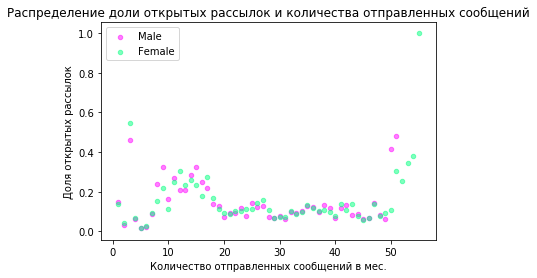

In [27]:
ax= report_by_gender_pivot[report_by_gender_pivot['pc_o']['Male']>0].plot(kind='scatter', y=('pc_o', 'Male'), x='sent', alpha=0.5, label='Male', color='magenta')
report_by_gender_pivot[report_by_gender_pivot['pc_o']['Female']>0].plot(ax=ax,x='sent', y=('pc_o', 'Female'), kind='scatter', color='springgreen', alpha=0.5, label='Female')
plt.title('Распределение доли открытых рассылок и количества отправленных сообщений')
plt.xlabel("Количество отправленных сообщений в мес.")
plt.ylabel("Доля открытых рассылок")
ax.legend(['Male', 'Female'])
plt.show()

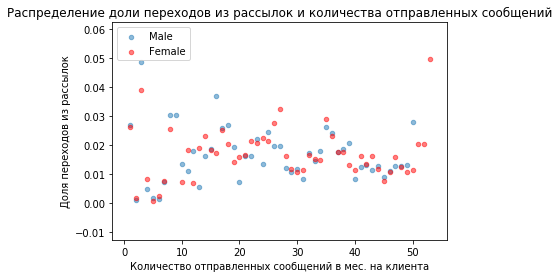

In [28]:
ax= report_by_gender_pivot[report_by_gender_pivot['pc_c']['Male']>0].plot(kind='scatter', y=('pc_c', 'Male'), x='sent', alpha=0.5)
report_by_gender_pivot[report_by_gender_pivot['pc_c']['Female']>0].plot(ax=ax,x='sent', y=('pc_c', 'Female'), kind='scatter', color='red', alpha=0.5)
plt.title('Распределение доли переходов из рассылок и количества отправленных сообщений')
plt.xlabel("Количество отправленных сообщений в мес. на клиента")
plt.ylabel('Доля переходов из рассылок')
ax.legend(['Male', 'Female'])
plt.show()

Визуально автор не видит различий в зависимости доли открытых рассылок (доли переходов из рассылок) для клиентов разного пола. Для дальнейшего анализа принимаем, что их нет.

### Возраст

Уберем некорректные данные по возрасту.

In [29]:
members.loc[members['age_id']>65, 'age_id'] = 0

In [30]:
members[members['age_id']>0].describe()

,age_id,sent,transactions
count,10918.000000,10918.000000,6651.000000
mean,30.136380,61.344569,1.745753
std,10.966293,57.189970,2.158984
min,14.000000,1.000000,1.000000
25%,21.000000,2.000000,1.000000
50%,28.000000,52.000000,1.000000
75%,37.000000,126.000000,2.000000
max,65.000000,177.000000,79.000000


Таблицу `report` сгруппируем по количеству отправленных сообщений в мес. на пользователя и возрастной группе.

In [31]:
report_by_age = report[report['age_group']!='no_age_group'].groupby(['age_group', 'sent']).agg({'delivered': 'sum', 'opened': 'sum', 'clicked': 'sum'}).reset_index()
report_by_age['pc_o'] = report_by_age['opened']/ report_by_age['delivered']
report_by_age['pc_c'] = report_by_age['clicked'] / report_by_age['delivered']
report_by_age_pivot = report_by_age.pivot_table(index='sent', columns='age_group', values=['pc_o', 'pc_c'], aggfunc='mean')
report_by_age_pivot = report_by_age_pivot.reset_index()


In [32]:
report_by_age_pivot.head()

sent      pc_c                                                    \
age_group          15-20     21-25     26-35     36-45     46-55       55+   
0          1.0  0.000000  0.000000  0.033557  0.045045  0.061224  0.058824   
1          2.0  0.001672  0.000000  0.000000  0.000000  0.016949  0.000000   
2          3.0  0.017544  0.025000  0.063333  0.058974  0.098039  0.058824   
3          4.0  0.009524  0.005618  0.005769  0.000000  0.016667  0.000000   
4          5.0  0.000000  0.001418  0.002395  0.000962  0.000000  0.000000   

                    pc_o                                                    \
age_group  <14     15-20     21-25     26-35     36-45     46-55       55+   
0          NaN  0.064220  0.138614  0.127517  0.153153  0.306122  0.117647   
1          0.0  0.021739  0.044393  0.048936  0.059748  0.050847  0.083333   
2          0.0  0.273183  0.480556  0.615000  0.705128  0.699346  0.647059   
3          NaN  0.059524  0.053371  0.082692  0.052239  0.033333  0.019231   
4          0.1  0.003384  0.022695  0.041916  0.027885  0.026667  0.021818   

                
age_group  <14  
0          NaN  
1          0.0  
2          0.0  
3          NaN  
4          0.1

Также как с полом будем изучать графики.

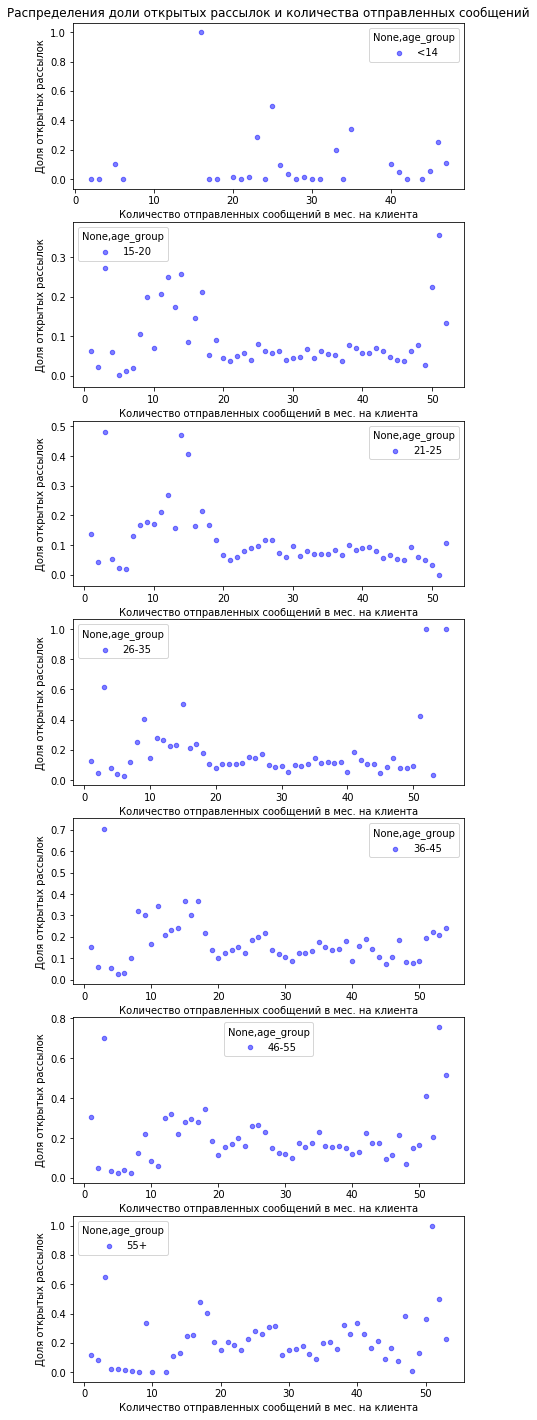

In [33]:
nrow = 7
ncol = 1

fig, axs = plt.subplots(nrow, ncol, figsize=(7,25))
cats = ['<14', '15-20','21-25', '26-35', '36-45', '46-55', '55+']
for i, ax in enumerate(fig.axes):
    if i ==0:
        ax.set_title('Распределения доли открытых рассылок и количества отправленных сообщений')
    report_by_age_pivot.plot(ax=ax, kind='scatter', y=('pc_o', cats[i]), x='sent', color='blue', alpha=0.5, label=cats[i])
    ax.set_xlabel("Количество отправленных сообщений в мес. на клиента")
    ax.set_ylabel('Доля открытых рассылок')

In [34]:
print('Количество людей, с возрастом <14:', members[members['age_group']=='<14']['consumer_seuci_id'].nunique())

Количество людей, с возрастом <14: 18


Различий также не видно, за исключением группы школьников (<14). Их всего 18, поэтому вычеркиваем возраст из признаков, влияющих на оптимальную частоту рассылок.

### Время жизни клиента от последней покупки

В `report` ранее подтянули на каждый месяц-пользователь дату последней покупки, от нее посчитали текущий лайфтайм. Посмотрим как ведут себя клиенты в зависмости от него.

In [35]:
report_by_tr_lt = report[(report['tr_lifetime']>0) & (report['tr_lifetime']<12)].groupby('tr_lifetime').agg({'delivered': 'sum', 'opened': 'sum', 'clicked': 'sum'}).reset_index()
report_by_tr_lt['pc_o'] = report_by_tr_lt['opened'] / report_by_tr_lt['delivered']
report_by_tr_lt['pc_c'] = report_by_tr_lt['clicked'] / report_by_tr_lt['delivered']


In [36]:
zero_part = []
ones_part= []
count = []
for lt in range(1, 12):

    zero_part.append(report[(report['tr_lifetime']==lt) & (report['pc_o']==0)]['sent'].count() / report[(report['tr_lifetime']==lt)]['sent'].count())
    ones_part.append(report[(report['tr_lifetime']==lt) & (report['pc_o']==1)]['sent'].count() / report[(report['tr_lifetime']==lt)]['sent'].count())
  
    count.append(report[(report['tr_lifetime']==lt)]['pc_o'].count())
df = pd.DataFrame({'zero_part':zero_part, 'ones_part':ones_part, 'count':count, 'lt':range(1,12)})

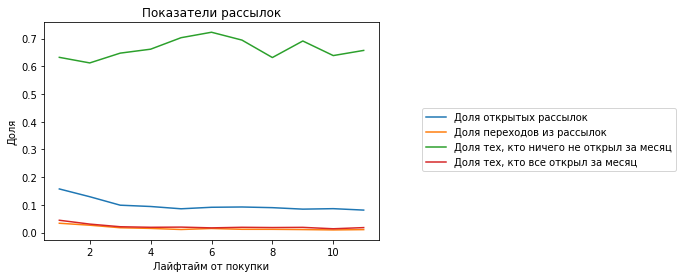

In [37]:
ax = report_by_tr_lt.plot(x='tr_lifetime', y='pc_o', label = 'Доля открытых рассылок')
report_by_tr_lt.plot(ax=ax, x='tr_lifetime', y='pc_c', label = 'Доля переходов из рассылок')
df.plot(ax=ax, x='lt', y='zero_part', label = 'Доля тех, кто ничего не открыл за месяц')
df.plot(ax=ax, x='lt', y='ones_part', label = 'Доля тех, кто все открыл за месяц')
plt.title('Показатели рассылок')
plt.xlabel("Лайфтайм от покупки")
plt.ylabel('Доля')
plt.legend(bbox_to_anchor=(1.6, 0.6),
           bbox_transform=plt.gcf().transFigure)
plt.show()

 **Видим, что 
поведение пользователей зависит от времени, прошедшего с их последней покупки.**<br>Будем использовать его как признак для определения оптимального количества рассылок.

### Расчет оптимального количества рассылок

Построим графики распределения доли открытия рассылок от количества отправляемых писем в месяц для каждого периода лайфтайма.

 Период 1


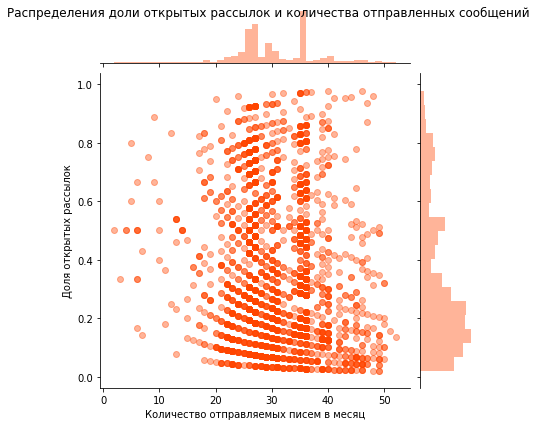

 Период 2


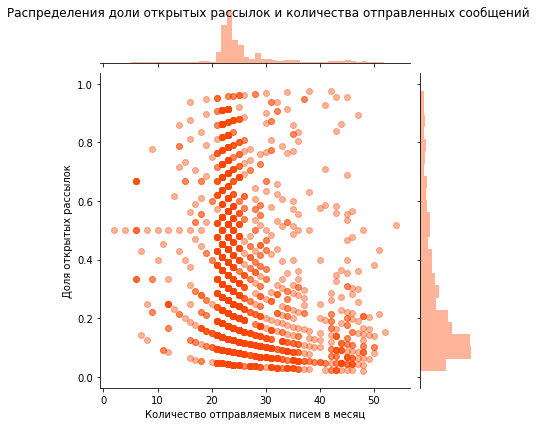

 Период 3


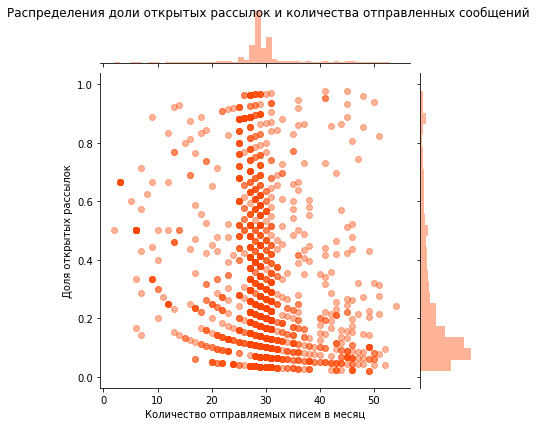

 Период 4


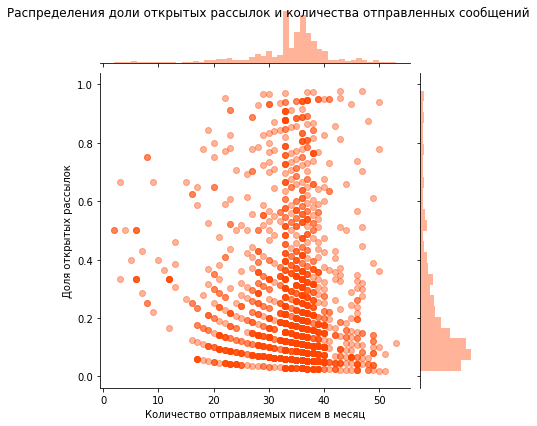

 Период 5


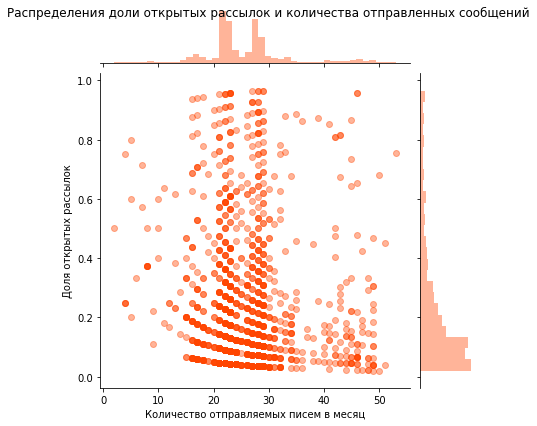

 Период 6


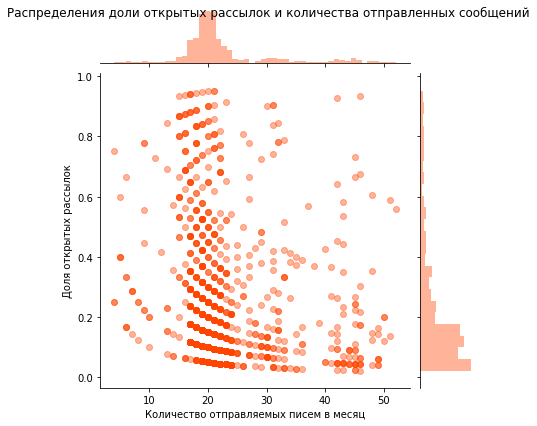

 Период 7


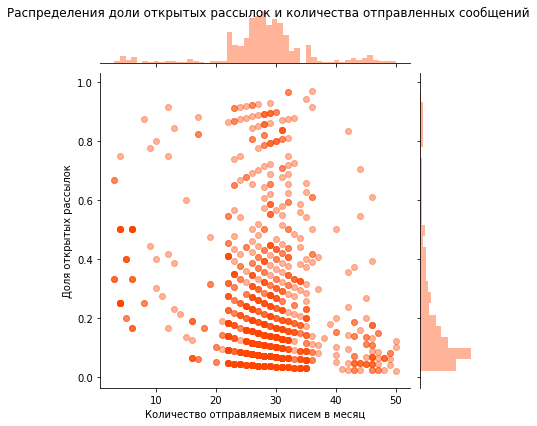

 Период 8


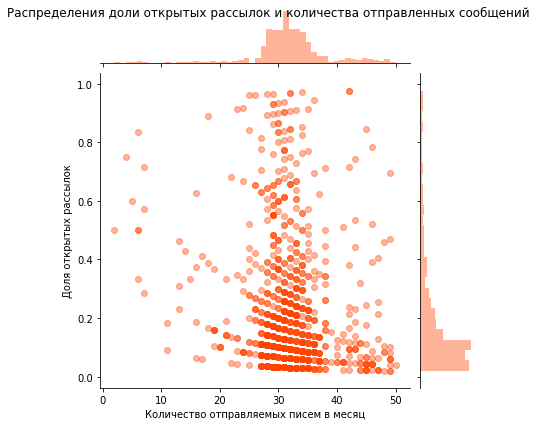

 Период 9


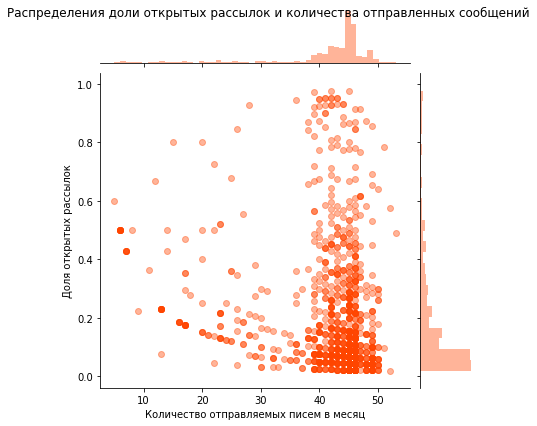

 Период 10


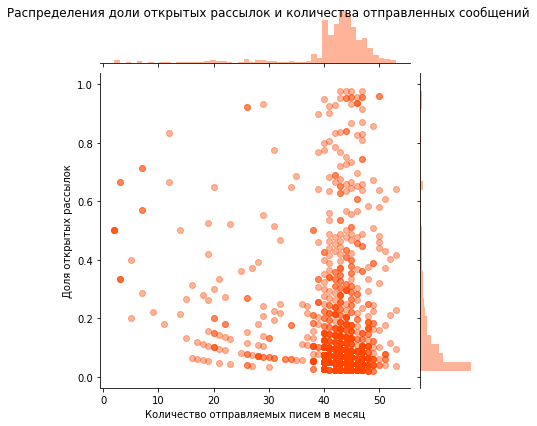

 Период 11


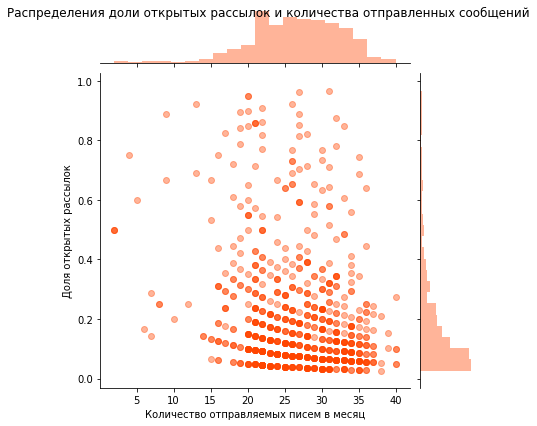

In [38]:
for lt in range(1, 12):
  print("\033[1m Период", lt)
  #print('zero part:', report[(report['tr_lifetime']==lt) & (report['pc_o']==0)]['month'].count() / report[(report['tr_lifetime']==lt)]['month'].count())
  #print('ones part:', report[(report['tr_lifetime']==lt) & (report['pc_o']==1)]['month'].count() / report[(report['tr_lifetime']==lt)]['month'].count())
  #print('mean:', report[(report['tr_lifetime']==lt)]['pc_o'].mean())
  #print('count:', report[(report['tr_lifetime']==lt)]['pc_o'].count())
  #report_w_tr_lt[report_w_tr_lt['tr_lifetime']==lt].plot(kind='scatter', x='sent', y='pc_o', alpha=0.01)
  #report_w_tr_lt[(report_w_tr_lt['tr_lifetime']==lt) & (report_w_tr_lt['pc_o']>0)].plot(kind='scatter', x='sent', y='pc_o', alpha=0.05)
  #sns.jointplot(x='sent', y='pc_o', data=report_w_tr_lt[(report_w_tr_lt['tr_lifetime']==lt) & (report_w_tr_lt['pc_o']>0)& (report_w_tr_lt['pc_o']<1)], alpha=0.4, color='orangered')
  p = sns.jointplot(x='sent', y='pc_o', data=report[(report['tr_lifetime']==lt) & (report['pc_o']>0)& (report['pc_o']<1)], alpha=0.4, color='orangered')
  p.fig.suptitle("Распределения доли открытых рассылок и количества отправленных сообщений")
  p.set_axis_labels('Количество отправляемых писем в месяц', 'Доля открытых рассылок', fontsize=10)
  
  plt.show()

На графиках видно, что в приинципе для каждого периода можно найти область (области), в которой доля открытых рассылок максимальна. Соответствующие значения количества отправляемых писем в месяц возьмем за оптимальные. <br><br>
Посмотрим на них в цифрах:<br>
(Группы выбирал вручную по критерию равенства количества доставленных писем)

In [39]:
def get_sent_group( row):  
    if row['sent'] <= 25.0:
        return '<25'
    
    elif 27.0<row['sent'] <= 35.0:
        return '28-35'
    elif 35.0<row['sent']:
        return '>35'
    else:
        return row['sent']
def table (lt):
  print('\033[1mЗначения показателей взаимодействий с рассылками в периоде',lt)
  #a = report[report['lifetime']==lt].groupby('sent').agg({'pc_o': ['mean', 'median']}).reset_index()
  a = report[report['tr_lifetime']==lt].groupby('sent').agg({'delivered': 'sum', 'opened': 'sum', 'clicked': 'sum'}).reset_index()
  a['pc_o'] = a['opened'] / a['delivered']
  a['pc_c'] = a['clicked'] / a['delivered']
  a['sent_group'] =a.apply(get_sent_group, axis=1)
  b = a.groupby('sent_group').agg({'delivered': 'sum', 'opened': 'sum', 'clicked': 'sum'}).reset_index()
  b['pc_o'] = round((b['opened'] / b['delivered'])*100, 1)
  b['pc_c'] = round((b['clicked'] / b['delivered'])*100, 1)
  #a.columns = a.columns.droplevel()
  display(b.sort_values('pc_o', ascending=False))

In [40]:
table(1)

Значения показателей взаимодействий с рассылками в периоде 1


,sent_group,delivered,opened,clicked,pc_o,pc_c
1,27,40149.0,7572.0,1646.0,18.9,4.1
0,26,37336.0,6649.0,1365.0,17.8,3.7
3,<25,29556.0,4696.0,1045.0,15.9,3.5
2,28-35,88868.0,13081.0,2652.0,14.7,3.0
4,>35,69544.0,9757.0,2187.0,14.0,3.1


In [41]:
def get_sent_group( row):  
    if row['sent'] <= 21.0:
        return '0-21'
    elif 24.0<row['sent']:
        return '>24'
    else:
        return row['sent']

table(2)

Значения показателей взаимодействий с рассылками в периоде 2


,sent_group,delivered,opened,clicked,pc_o,pc_c
3,0-21,12385.0,2252.0,504.0,18.2,4.1
0,22,29370.0,4428.0,980.0,15.1,3.3
1,23,41653.0,6269.0,1363.0,15.1,3.3
4,>24,77721.0,8388.0,1513.0,10.8,1.9
2,24,22656.0,2417.0,505.0,10.7,2.2


In [42]:
def get_sent_group( row):  
    if row['sent'] <= 26.0:
        return '0-26'
    if 26<row['sent'] <= 28.0:
        return '27-28'    
    elif 30<row['sent']:
        return '>30'
    else:
        return row['sent']

table(3)

Значения показателей взаимодействий с рассылками в периоде 3


,sent_group,delivered,opened,clicked,pc_o,pc_c
3,27-28,14124.0,4383.0,707.0,31.0,5.0
2,0-26,13444.0,3909.0,579.0,29.1,4.3
4,>30,79958.0,5447.0,991.0,6.8,1.2
0,29,65250.0,4292.0,878.0,6.6,1.3
1,30,23160.0,1306.0,229.0,5.6,1.0


In [43]:
def get_sent_group( row):  
    if row['sent'] <= 30.0:
        return '0-30'
      
    if 30<row['sent'] <= 33.0:
        return '31-33'    
    if 33<row['sent'] <= 35.0:
        return '34-35'    
     
    elif 36<row['sent']:
        return '>36'
    else:
        return row['sent']

table(4)

Значения показателей взаимодействий с рассылками в периоде 4


,sent_group,delivered,opened,clicked,pc_o,pc_c
1,0-30,29306.0,3079.0,478.0,10.5,1.6
4,>36,63511.0,6443.0,951.0,10.1,1.5
3,34-35,26790.0,2673.0,576.0,10.0,2.2
2,31-33,43960.0,3792.0,572.0,8.6,1.3
0,36,37764.0,2933.0,424.0,7.8,1.1


In [44]:
def get_sent_group( row):  
    if row['sent'] <= 20.0:
        return '0-20'
    if 20<row['sent'] <= 22.0:
        return '21-22'    
    if 23<row['sent'] <= 26.0:
        return '24-26'    
    if 26<row['sent'] <= 28.0:
        return '27-28'    
    elif 28<row['sent']:
        return '>28'
    else:
        return row['sent']

table(5)

Значения показателей взаимодействий с рассылками в периоде 5


,sent_group,delivered,opened,clicked,pc_o,pc_c
5,>28,33150.0,3495.0,459.0,10.5,1.4
1,0-20,13478.0,1253.0,151.0,9.3,1.1
4,27-28,25444.0,2211.0,274.0,8.7,1.1
2,21-22,26017.0,1936.0,225.0,7.4,0.9
0,23,21896.0,1573.0,183.0,7.2,0.8
3,24-26,14034.0,1017.0,172.0,7.2,1.2


In [45]:
def get_sent_group( row):  
    if row['sent'] <= 18.0:
        return '0-18'
    if 18<row['sent'] <= 20.0:
        return '19-20'    
       
    elif 21<row['sent']:
        return '>21'
    else:
        return row['sent']

table(6)

Значения показателей взаимодействий с рассылками в периоде 6


,sent_group,delivered,opened,clicked,pc_o,pc_c
1,0-18,14983.0,2374.0,284.0,15.8,1.9
3,>21,34936.0,3109.0,519.0,8.9,1.5
2,19-20,25347.0,1849.0,320.0,7.3,1.3
0,21,13797.0,787.0,176.0,5.7,1.3


In [46]:
def get_sent_group( row):  
    if row['sent'] <= 24.0:
        return '0-24'
     
    if 24<row['sent'] <= 27:
        return '25-27'       
    elif 29<row['sent']:
        return '>29'
    else:
        return row['sent']

table(7)

Значения показателей взаимодействий с рассылками в периоде 7


,sent_group,delivered,opened,clicked,pc_o,pc_c
1,29,7134.0,937.0,108.0,13.1,1.5
4,>29,41132.0,4024.0,553.0,9.8,1.3
0,28,9268.0,868.0,138.0,9.4,1.5
3,25-27,24118.0,1943.0,219.0,8.1,0.9
2,0-24,16565.0,1282.0,129.0,7.7,0.8


In [47]:
def get_sent_group( row):  
    if row['sent'] <= 26.0:
        return '0-26'
    
    if 29<row['sent'] <= 35:
        return '30-35'   
    if 26<row['sent'] <= 29:
        return '27-29'          
    elif 35<row['sent']:
        return '>35'
    else:
        return row['sent']

table(8)

Значения показателей взаимодействий с рассылками в периоде 8


,sent_group,delivered,opened,clicked,pc_o,pc_c
0,0-26,3553.0,662.0,61.0,18.6,1.7
3,>35,17149.0,1555.0,204.0,9.1,1.2
2,30-35,54691.0,4707.0,680.0,8.6,1.2
1,27-29,23157.0,1923.0,198.0,8.3,0.9


In [48]:
def get_sent_group( row):  
    if row['sent'] <= 21.0:
        return '0-21'
    if 21<row['sent'] <= 39:
        return '22-39'  
    
    if 39<row['sent'] <= 43:
        return '40-43'                    
    elif 45<row['sent']:
        return '>45'
    else:
        return row['sent']

table(9)

Значения показателей взаимодействий с рассылками в периоде 9


,sent_group,delivered,opened,clicked,pc_o,pc_c
4,40-43,23163.0,4008.0,386.0,17.3,1.7
3,22-39,8959.0,1285.0,171.0,14.3,1.9
0,44,8140.0,790.0,129.0,9.7,1.6
5,>45,43399.0,2916.0,467.0,6.7,1.1
2,0-21,8003.0,374.0,43.0,4.7,0.5
1,45,39780.0,1724.0,210.0,4.3,0.5


In [49]:
def get_sent_group( row):  
    if row['sent'] <= 21.0:
        return '0-21'
    if 21<row['sent'] <= 39:
        return '22-39'  
    if 39<row['sent'] <= 44:
        return '40-44'  
                        
    elif 45<row['sent']:
        return '>45'
    else:
        return row['sent']

table(10)

Значения показателей взаимодействий с рассылками в периоде 10


,sent_group,delivered,opened,clicked,pc_o,pc_c
4,>45,19461.0,2956.0,274.0,15.2,1.4
0,45,9405.0,1060.0,110.0,11.3,1.2
2,22-39,7977.0,828.0,112.0,10.4,1.4
1,0-21,2564.0,259.0,15.0,10.1,0.6
3,40-44,73693.0,4641.0,558.0,6.3,0.8


In [50]:
def get_sent_group( row):  
    if row['sent'] <= 21:
        return '0-21'
    if 21<row['sent'] <= 25:
        return '22-25' 
    if 25<row['sent'] <= 29:
        return '26-29'  
    if 29<row['sent'] <= 33:
        return '30-33'  
                        
    elif 34<row['sent']:
        return '>34'
    else:
        return row['sent']

table(11)

Значения показателей взаимодействий с рассылками в периоде 11


,sent_group,delivered,opened,clicked,pc_o,pc_c
1,0-21,9017.0,1173.0,108.0,13.0,1.2
4,30-33,14631.0,1176.0,155.0,8.0,1.1
3,26-29,16595.0,1297.0,203.0,7.8,1.2
5,>34,6417.0,436.0,62.0,6.8,1.0
0,34,3604.0,239.0,40.0,6.6,1.1
2,22-25,14380.0,914.0,113.0,6.4,0.8


Цифры подтвердили наблюдения на графиках. <br>
Для каждого периода жизни клиента (от покупки) существует оптимальное значение (или группа значений) количества отправляемых сообщений в месяц, при котором доля открытых сообщенйи максимальна. <br>
При выборе конечного значения из группы или групп с близкими показателями оптимальности будем выбирать максимальное количество рассылок, руководствуюясь тем, что при условно равной доле открытия сообщений переходов будет тем больше, чем больше отправлено сообщений.<br>
Бонусом получаем, что доля переходов корреллирует с долей открытия.

Но у нас остались пользователи, которые пока не совершали покупок и не начали свой лайфтайм. Смотрим распределения по ним.

 Период до покупки


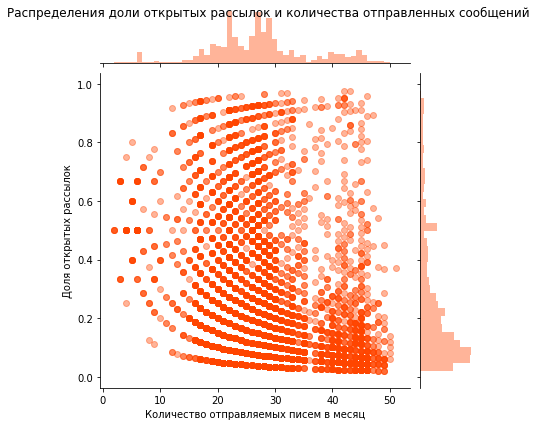

In [51]:
#print('zero part:', report[(report['tr_lifetime'].isna()) & (report['pc_o']==0)]['month'].count() / report[(report['tr_lifetime'].isna())]['month'].count())
#print('ones part:', report[(report['tr_lifetime'].isna()) & (report['pc_o']==1)]['month'].count() / report[(report['tr_lifetime'].isna())]['month'].count())
##print('mean:', report[(report['tr_lifetime'].isna())]['pc_o'].mean())
#print('count:', report[(report['tr_lifetime'].isna())]['pc_o'].count())
print("\033[1m Период до покупки")
p =sns.jointplot(x='sent', y='pc_o', data=report[(report['tr_lifetime'].isna()) & (report['pc_o']>0)& (report['pc_o']<1)], alpha=0.4, color='orangered')
p.fig.suptitle("Распределения доли открытых рассылок и количества отправленных сообщений")
p.set_axis_labels('Количество отправляемых писем в месяц', 'Доля открытых рассылок', fontsize=10)
plt.show()

In [52]:
def get_sent_group( row):  
    if row['sent'] <= 21:
        return '0-21'
    if 21<row['sent'] <= 25:
        return '22-25' 
    if 25<row['sent'] <= 29:
        return '26-29'  
    if 29<row['sent'] <= 32:
        return '30-32'  
                        
    elif 32<row['sent']:
        return '>32'
    else:
        return row['sent']


print('\033[1mЗначения показателей взаимодействий с рассылками в периоде без покупок')
#a = report[report['lifetime']==lt].groupby('sent').agg({'pc_o': ['mean', 'median']}).reset_index()
a = report[report['tr_lifetime'].isna()].groupby('sent').agg({'delivered': 'sum', 'opened': 'sum', 'clicked': 'sum'}).reset_index()
a['pc_o'] = a['opened'] / a['delivered']
a['pc_c'] = a['clicked'] / a['delivered']
a['sent_group'] =a.apply(get_sent_group, axis=1)
b = a.groupby('sent_group').agg({'delivered': 'sum', 'opened': 'sum', 'clicked': 'sum'}).reset_index()
b['pc_o'] = round((b['opened'] / b['delivered'])*100, 1)
b['pc_c'] = round((b['clicked'] / b['delivered'])*100, 1)
#a.columns = a.columns.droplevel()
display(b.sort_values('pc_o', ascending=False))

Значения показателей взаимодействий с рассылками в периоде без покупок


,sent_group,delivered,opened,clicked,pc_o,pc_c
0,0-21,109062.0,10466.0,1125.0,9.6,1.0
1,22-25,144277.0,12049.0,2419.0,8.4,1.7
4,>32,177423.0,12450.0,1908.0,7.0,1.1
2,26-29,285883.0,18609.0,2948.0,6.5,1.0
3,30-32,75743.0,4469.0,712.0,5.9,0.9


Здесь картина не такая четкая, но все равно можно выделить необходимые значения. Тем более, что без покупок у нас пользователи долго оставаться не будут (а те, кто будет, нам не нужны).


Сформируем таблицу с конечными оптимальными значениями количества отправляемых сообщений в месяц по лайфтаймам. <br>

In [53]:
result_by_lt = pd.DataFrame({'Lifetime': range(1,12)})
a = pd.DataFrame({'Lifetime': ['без покупок']})
result_by_lt = result_by_lt.append(a)
result_by_lt['result'] = [27,21,28,36,28,18,29,26,43,45,21,21]
print('\033[1mОптимальное количество рассылок в месяц по лайфтайму')
result_by_lt

Оптимальное количество рассылок в месяц по лайфтайму


,Lifetime,result
0,1,27
1,2,21
2,3,28
3,4,36
4,5,28
5,6,18
6,7,29
7,8,26
8,9,43
9,10,45


Раздаем значения клиентам:

In [54]:
#df = report['id'].value_counts().reset_index()['index'].reset_index()
#df = df.merge(report[['id', 'tr_lifetime']], how='left', left_on='index', right_on='id')
df = report.groupby('id')['tr_lifetime'].max().reset_index()
df['fw_tr_lifetime'] = df['tr_lifetime']+1
df['fw_tr_lifetime_corr'] = df['fw_tr_lifetime'].where(((df['fw_tr_lifetime']<11) | (df['fw_tr_lifetime'].isna())), 11)
df = df.fillna('без покупок')
df = df.merge(result_by_lt, how='left', left_on='fw_tr_lifetime_corr', right_on='Lifetime')
df

,id,tr_lifetime,fw_tr_lifetime,fw_tr_lifetime_corr,Lifetime,result
0,003GH1K9GPLAB0WG,без покупок,без покупок,без покупок,без покупок,21
1,0049U5ZF5M0KFYTZ,13,14,11,11,21
2,006ZYWZO9M7FS9BT,7,8,8,8,26
3,00720YKABZ6J9ZJ1,без покупок,без покупок,без покупок,без покупок,21
4,009LQ66BFK5BIS1S,без покупок,без покупок,без покупок,без покупок,21
...,...,...,...,...,...,...
14060,ZZGUEFBYPRPHV4L7,без покупок,без покупок,без покупок,без покупок,21
14061,ZZIMU0NWLG08HFXH,без покупок,без покупок,без покупок,без покупок,21
14062,ZZKXJSUCL1TDAXTC,без покупок,без покупок,без покупок,без покупок,21
14063,ZZPKQZAEI42CGS93,13,14,11,11,21


In [55]:
df.to_csv('1.csv')

К текущему лайфтайму добавили единицу (планируем на следующий). Значения лайфтаймов, которые превышают 11, пришлось заменить на 11, т.к. данные за последующие отсутствуют.

Ссылка на гугл-таблицу: 
https://docs.google.com/spreadsheets/d/1THf0RXGbJEj7dYHeGjIS6TTjW20LZsWJPE4Z06XAMbo/edit#gid=1745512898

## Задача 2.1 Проверить гипотезу о “пассивной отписке”

Гипотеза: Когда человеку показалось, что ему пишут слишком много, он просто перестает открывать рассылки, хоть и не готов отписываться

Посмотрим сначала на всех пользователей в разбивке по среднему числу отправленных сообщений в месяц

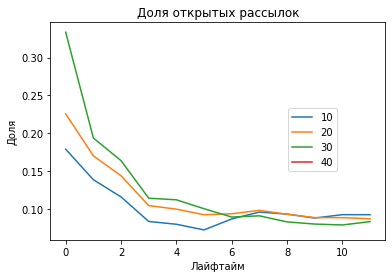

In [56]:
fig, ax = plt.subplots()
for s in range (10,50,10):
  sent = s  
  df = report.groupby('id')['sent'].mean().reset_index()
  ids = df.query('sent>@sent')['id'].unique()
  report2 = report.query('id in @ids')
  report_by_tr_lt = report2.groupby(['lifetime']).agg({'delivered': 'sum', 'opened': 'sum', 'clicked': 'sum'}).reset_index()
  report_by_tr_lt['pc_o'] = report_by_tr_lt['opened'] / report_by_tr_lt['delivered']
  report_by_tr_lt['pc_c'] = report_by_tr_lt['clicked'] / report_by_tr_lt['delivered']
  
  report_by_tr_lt.plot(ax=ax, x='lifetime', y='pc_o', label = sent)
  plt.title('Доля открытых рассылок')
  plt.xlabel("Лайфтайм")
  plt.ylabel('Доля')
  plt.legend(bbox_to_anchor=(0.8, 0.6),
            bbox_transform=plt.gcf().transFigure)
plt.show()
  


Видим, что доля открытия уменьшается одинаково для всего диапазона количества отппавляемых писем.

Однако, как мы выясниили, когда рассматривали время жизни клиента, снижение доли открытых писем связано с его увеличением после покупки. .<br>
Поэтому гипотезу будем проверять на клиентах, которые не покупали вообще или делали покупку больше четырех месяцев назад.

Для проверки данной гипотезы добавим в `report` дропрейт доли открытых рассылок месяц к месяцу.

In [57]:
report = report.sort_values(['id', 'month'])
report['fw_droprate'] = 1 - report.groupby('id')['pc_o'].shift(-1).div(report['pc_o'])
report['droprate'] = np.NaN
report.loc[report['pc_o'].shift(1)>0, 'droprate'] = 1 - report.groupby('id')['pc_o'].shift(0).div(report['pc_o'].shift(1))

Возьмем клиентов, которые читали рассылки (pc_o>0.1) хотя бы два месяца подряд(droprate<0.3), и которые перестали их читать в следующем месяце (fw_droprate>0.5).

In [58]:
nan = np.NaN
q = report.groupby('id')['nr_of_transactions'].sum().reset_index()
no_buy_ids =q[q['nr_of_transactions']==0]['id']
print('Их кол-во получилось', report.query('pc_o>0.1 and droprate<0.3 and fw_droprate>0.5 and (tr_lifetime>=4 or id in @no_buy_ids)')['id'].nunique())

Их кол-во получилось 1527


Теперь посчитаем их средние доли открытия рассылок за первую половину периодов их существования и вторую.

In [59]:
dict_us = {}
for i in report.query('pc_o>0.1 and droprate<0.3 and fw_droprate>0.5 and (id in @no_buy_ids or tr_lifetime>=4)')['id'].value_counts().reset_index()['index'].to_list():
  dflen = report[report['id'] == i]['pc_o'].count().item() // 2
  firstpart_sum = report[report['id'] == i].head(dflen)['pc_o'].sum()
  firstpart_count = report[report['id'] == i].head(dflen)['pc_o'].count()
  firstpart_mean = firstpart_sum / firstpart_count
  secondpart_sum = report[report['id'] == i]['pc_o'].sum() - firstpart_sum
  secondpart_count = report[report['id'] == i]['pc_o'].count() - firstpart_count
  secondpart_mean = secondpart_sum / secondpart_count
  dict_us[i] = [firstpart_mean, secondpart_mean]


T:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [60]:
df = pd.DataFrame.from_dict(dict_us)
df = df.transpose()
print('средняя доля по выбранным клиентам за первую половину периодов / за вторую')
df[0].mean(), '/', df[1].mean()

средняя доля по выбранным клиентам за первую половину периодов / за вторую


(0.25568871852495134, '/', 0.16011599879888094)

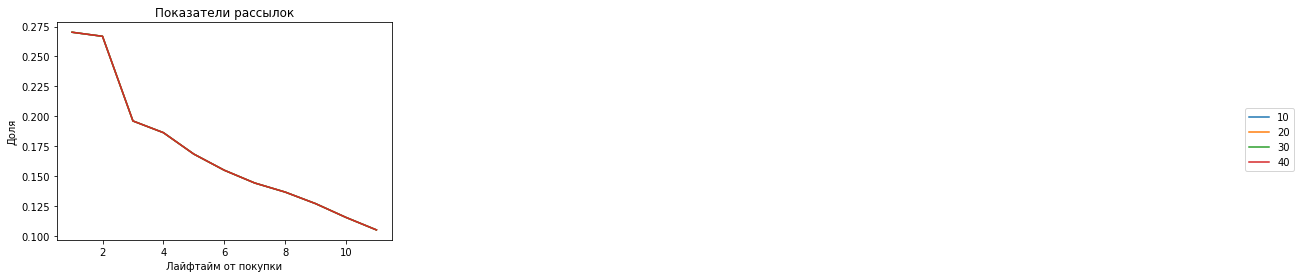

In [61]:
fig, ax = plt.subplots()
for s in range (10,50,10):
  sent = s
 
  
  ids= report.query('pc_o>0.1 and droprate<0.3 and fw_droprate>0.5')['id'].value_counts().reset_index()['index'].to_list()
  report2 = report.query('id in @ids and (tr_lifetime>=4 or id in @no_buy_ids)')
  report_by_tr_lt = report2.groupby(['lifetime']).agg({'delivered': 'sum', 'opened': 'sum', 'clicked': 'sum'}).reset_index()
  report_by_tr_lt['pc_o'] = report_by_tr_lt['opened'] / report_by_tr_lt['delivered']
  report_by_tr_lt['pc_c'] = report_by_tr_lt['clicked'] / report_by_tr_lt['delivered']
  
  report_by_tr_lt.plot(ax=ax, x='lifetime', y='pc_o', label = sent)
  plt.title('Показатели рассылок')
  plt.xlabel("Лайфтайм от покупки")
  plt.ylabel('Доля')
  plt.legend(bbox_to_anchor=(3, 0.6),
            bbox_transform=plt.gcf().transFigure)
  
plt.show()
  


Среднее количество рассылок таким клиентам получилось более 40 - выше среднего.

Видим, что явление описанное в гипотезе имеет место быть, но на относительно небольшой доле клиентов (10%).

## Задача 2.2 Проверить гипотезу о потере интереса клиента после покупки

Клиент совершает покупку и какое-то время теряет интерес к новостным рассылкам, во всяком случае рассылки на пользователя не генерят продажи

In [62]:
transactions.groupby('consumer_seuci_id').count().mean()


order_date_id         1.722496
nr_of_transactions    1.722496
transaction_month     1.722496
dtype: float64

В среднем клиент совершает не более двух покупок за год, соответственно после покупки рассылки не будут генерить продажи в течение шести месяцев.

Как выяснили ранее доля просмотренных сообщений в первые два месяца после покупки выше, чем в последующие периоды (14% против 9%). 
Проверим это еще раз:

In [63]:
def get_prev_buy(row):
    if row['prev_1_buy'] >0:
        return 1
    if row['prev_2_buy'] >0:
        return 2
    else:
        return 0
report['prev_buy'] = report.apply(get_prev_buy, axis =1)

In [64]:
df = report.groupby(['id', 'prev_buy']).agg({
                                                  'sent':'sum', 
                                                   'delivered':'sum', 
                                                   'opened':'sum',
                                                   'clicked':'sum',
                                                   'unsubscribed':'sum'}).reset_index()
df['pc_o'] = df['pc_o_0'] = df['opened']/df['delivered']
df['pc_c'] = df['clicked']/df['delivered']
df = df.pivot_table(index='id', columns='prev_buy', values=['pc_o', 'pc_c'], aggfunc = 'mean').reset_index()

df['delta1_o']= df['pc_o'][1] - df['pc_o'][0]
df['delta2_o']= df['pc_o'][2] - df['pc_o'][0]
df['delta1_c']= df['pc_c'][1] - df['pc_c'][0]
df['delta2_c']= df['pc_c'][2] - df['pc_c'][0]

df

id      pc_c                          pc_o            \
prev_buy                           0         1         2         0         1   
0         003GH1K9GPLAB0WG  0.000000       NaN       NaN  0.000000       NaN   
1         0049U5ZF5M0KFYTZ  0.018868  0.000000  0.000000  0.146226  1.000000   
2         006ZYWZO9M7FS9BT  0.000000  0.000000  0.157895  0.195745  0.696970   
3         00720YKABZ6J9ZJ1  0.000000       NaN       NaN  0.000000       NaN   
4         009LQ66BFK5BIS1S  0.000000       NaN       NaN  0.000000       NaN   
...                    ...       ...       ...       ...       ...       ...   
14054     ZZGUEFBYPRPHV4L7  0.000000       NaN       NaN  0.000000       NaN   
14055     ZZIMU0NWLG08HFXH  0.000000       NaN       NaN  0.000000       NaN   
14056     ZZKXJSUCL1TDAXTC  0.000000       NaN       NaN  0.000000       NaN   
14057     ZZPKQZAEI42CGS93  0.000000  0.000000  0.000000  0.000000  0.000000   
14058     ZZZEACTRF1D49SYO  0.073333  0.038462  0.000000  0.220000  0.269231   

                    delta1_o  delta2_o  delta1_c  delta2_c  
prev_buy         2                                          
0              NaN       NaN       NaN       NaN       NaN  
1         1.000000  0.853774  0.853774 -0.018868 -0.018868  
2         0.368421  0.501225  0.172676  0.000000  0.157895  
3              NaN       NaN       NaN       NaN       NaN  
4              NaN       NaN       NaN       NaN       NaN  
...            ...       ...       ...       ...       ...  
14054          NaN       NaN       NaN       NaN       NaN  
14055          NaN       NaN       NaN       NaN       NaN  
14056          NaN       NaN       NaN       NaN       NaN  
14057     0.166667  0.000000  0.166667  0.000000  0.000000  
14058     0.026667  0.049231 -0.193333 -0.034872 -0.073333  

[14059 rows x 11 columns]

In [65]:
df[['delta1_o', 'delta2_o', 'delta1_c', 'delta2_c']].mean()

          prev_buy
delta1_o              0.057207
delta2_o              0.031921
delta1_c              0.017205
delta2_c              0.012206
dtype: float64

In [66]:
engagements['sent'].sum()  / 12

197327.5

In [67]:
report['sent'].sum() / 12  / report['id'].nunique()

14.029683611802346

Так и получилось: в первый месяц после покупки средняя доля просмотренных сообщений на 57% выше, чем в остальные месяцы, а во втором месяце на 33%. Доля клиенто-месяцев, в которых пользователи открывали все рассылки,  в первые два месяца (4%) выше в 2 раза, чем в остальные. Доля клиенто-месяцев, в которых пользователи не открыли не одной рассылки,  в первые два месяца (62%) ниже на 8%, чем в остальные.<br>

Кликрейт также уеличивается в 2 раза до 2,6%.

## Общий вывод

По вопросу 1:
Для определения максимальной частоты рассылок рассматривались следующие факторы: пол клиента, возраст клиента, лайфтайм клиента от последней покупки. Первые два признака не влияют на реакцию клиента на рассылки. Для каждого лайфтайма существует оптимальное колиечство рассылок, при котором доля просмотренных сообщений максимальна. Оптимальное колиечство рассылок по клиенту было опредленно исходя из прогнозного лайфтайма клиента (на август 2020 года).<br>


По вопросу 2.1: Гипотеза о “пассивной отписке” (когда человеку показалось, что ему пишут слишком много, и он просто перестает открывать рассылки, хоть и не готов отписываться) подтверждена для небольшого количества клиентов (1,5 тыс. или 10%). На остальных клиентах большее влияние на снижение доли просмотренных сообщений влияет возврат к среднему после ее увеличения из-за совершения покупки.

По вопросу 2.2.: После совершения покупки, клиент не совершает повторную покупку в течение 6 месяцев, но при этом более активно смотрит приходящие рассылки (средняя доля просомтренных сообщений увеличивается на примерно 40%). Кликрейт также уеличивается в 2 раза до 2,6%.